In [1]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import tqdm


import warnings
warnings.filterwarnings("ignore")

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
new_transactions = pd.read_csv('data/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('data/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for i in ['authorized_flag', 'category_1']:
        df[i] = df[i].apply(lambda x: 1 if x == 'Y' else 0)
    return df
    
historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [3]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

In [4]:
train = read_data('data/train.csv')
test = read_data('data/test.csv')

target = train['target']
train.drop(columns=['target'], inplace=True)

In [5]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

auth_mean = historical_transactions.groupby(['card_id'])['authorized_flag'].agg(['sum', 'mean'])
auth_mean.columns = auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

In [6]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [7]:
display(historical_transactions.head(5))
print(historical_transactions.info())

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,...,37,1,0,0,0,0,1,0,0,4
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,...,16,1,0,0,0,0,1,0,0,9
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,...,16,1,0,0,0,0,1,0,0,9
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,...,2,1,0,0,0,0,1,0,0,2
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,...,34,1,0,0,0,0,1,0,0,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516909 entries, 115 to 29112313
Data columns (total 21 columns):
authorized_flag         int64
card_id                 object
city_id                 int64
category_1              int64
installments            int64
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
state_id                int64
subsector_id            int64
category_2_1.0          uint8
category_2_2.0          uint8
category_2_3.0          uint8
category_2_4.0          uint8
category_2_5.0          uint8
category_3_A            uint8
category_3_B            uint8
category_3_C            uint8
purchase_month          int64
dtypes: datetime64[ns](1), float64(1), int64(9), object(2), uint8(8)
memory usage: 288.0+ MB
None


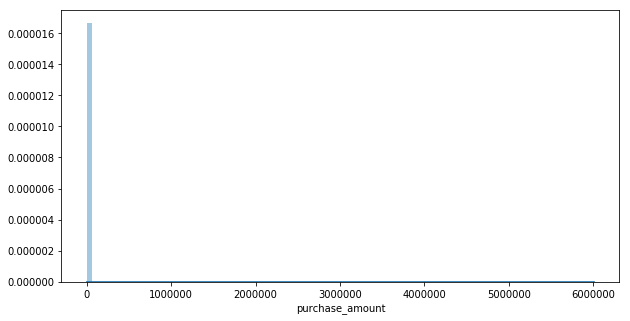

In [8]:
plt.figure(figsize=(10,5))
sns.distplot(historical_transactions['purchase_amount'], bins=100)
plt.show()

In [9]:
historical_transactions[(historical_transactions['purchase_amount'] > 0) &  (historical_transactions['purchase_amount'] < 1)]



,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month
410,0,C_ID_5037ff576e,211,0,1,307,M_ID_d23623b922,-3,0.075749,2017-09-18 20:08:26,...,19,0,0,1,0,0,0,1,0,9
414,0,C_ID_5037ff576e,11,0,1,333,M_ID_a21fe5f7ad,-5,0.495199,2017-07-19 17:54:52,...,10,0,1,0,0,0,0,1,0,7
465,0,C_ID_5037ff576e,330,0,1,307,M_ID_b0ec3307f7,-5,0.906008,2017-07-16 00:05:52,...,19,0,0,1,0,0,0,1,0,7
496,0,C_ID_5037ff576e,138,0,1,307,M_ID_fe69229f24,-3,0.485266,2017-09-27 14:15:48,...,19,1,0,0,0,0,0,1,0,9
505,0,C_ID_5037ff576e,17,0,1,307,M_ID_6929a11279,-1,0.004418,2017-11-13 00:00:00,...,19,0,0,0,1,0,0,1,0,11
508,0,C_ID_5037ff576e,344,0,1,307,M_ID_3d775a00f7,-6,0.755743,2017-06-27 19:41:30,...,19,0,1,0,0,0,0,1,0,6
517,0,C_ID_5037ff576e,20,0,1,307,M_ID_d23623b922,-6,0.755743,2017-06-23 18:55:07,...,19,0,0,1,0,0,0,1,0,6
1389,0,C_ID_4bed29d75c,69,0,6,561,M_ID_50f575c681,-2,0.244842,2017-11-17 19:26:05,...,7,1,0,0,0,0,0,0,1,11
1482,0,C_ID_93d201f55f,296,0,0,383,M_ID_29f6070ac8,-4,0.192249,2017-10-19 17:03:01,...,2,1,0,0,0,0,1,0,0,10
1541,0,C_ID_93d201f55f,296,0,0,383,M_ID_29f6070ac8,-4,0.192249,2017-10-19 17:03:32,...,2,1,0,0,0,0,1,0,0,10


In [10]:
# historical_transactions['VIP'] = historical_transactions['purchase_amount'] > 1000

In [11]:
# historical_transactions['VIP'] = (historical_transactions['purchase_amount'] > 1000) == 1
# historical_transactions['VIP'] = (historical_transactions['purchase_amount'] < 1000) == 0

In [12]:
# historical_transactions['VIP'] = historical_transactions['VIP'].apply(lambda x: 1 if x==True else 0)

In [13]:
# historical_transactions['VIP'].value_counts()

In [14]:
historical_transactions['purchase_amount_cat'] = historical_transactions['purchase_amount']

historical_transactions['purchase_amount_cat'] = historical_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                      int(-1) if x < 0.1 else x)

historical_transactions['purchase_amount_cat'] = historical_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                     int(-2) if (x >0.1 and
                                                                                                                 x < 1) else x)

historical_transactions['purchase_amount_cat'] = historical_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                     int(-3) if (x >1 and
                                                                                                                 x < 10) else x)

historical_transactions['purchase_amount_cat'] = historical_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                     int(-4) if (x >10 and
                                                                                                                 x < 1000)
                                                                                                      else x)

historical_transactions['purchase_amount_cat'] = historical_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                     int(-5) if x > 1000
                                                                                                      else x)

# historical_transactions['purchase_amount_cat'] = (historical_transactions['purchase_amount'] < 0.1) ==

# historical_transactions['purchase_amount_cat'] = ((historical_transactions['purchase_amount'] > 0.1) & \
#                                                   (historical_transactions['purchase_amount'] < 1)) == 2

# historical_transactions['purchase_amount_cat'] = ((historical_transactions['purchase_amount'] > 1) & 
#                                               historical_transactions['purchase_amount'] < 10) == 3

# historical_transactions['purchase_amount_cat'] = ((historical_transactions['purchase_amount'] > 10) & 
#                                               historical_transactions['purchase_amount'] < 1000) == 4

# historical_transactions['purchase_amount_cat'] = (historical_transactions['purchase_amount'] > 1000) == 5

In [15]:
historical_transactions['purchase_amount_cat'].value_counts()

-1.0    2322816
-2.0     103302
-3.0      84808
-4.0       5154
-5.0        829
Name: purchase_amount_cat, dtype: int64

In [16]:
ammout_cat = {-1: 'low', -2: 'middle', -3: 'middle_up', -4: 'high', -5: 'vip'}

In [17]:
historical_transactions['purchase_amount_cat'] = historical_transactions['purchase_amount_cat'].replace(ammout_cat)

In [18]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['purchase_amount_cat'])


In [19]:
historical_transactions.head(5)

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month,purchase_amount_cat_high,purchase_amount_cat_low,purchase_amount_cat_middle,purchase_amount_cat_middle_up,purchase_amount_cat_vip
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,...,0,1,0,0,4,0,1,0,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,...,0,1,0,0,9,0,1,0,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,...,0,1,0,0,9,0,1,0,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,...,0,1,0,0,2,0,1,0,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,...,0,1,0,0,7,0,1,0,0,0


In [20]:
# authorized_transactions['VIP'] =  authorized_transactions['purchase_amount'].apply(lambda x:
#                                                                                               1 if x > 1000 else 0)

In [21]:
authorized_transactions['purchase_amount_cat'] = authorized_transactions['purchase_amount']

authorized_transactions['purchase_amount_cat'] = authorized_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                      int(-1) if x < 0.1 else x)

authorized_transactions['purchase_amount_cat'] = authorized_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                     int(-2) if (x >0.1 and
                                                                                                                 x < 1) else x)

authorized_transactions['purchase_amount_cat'] = authorized_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                     int(-3) if (x >1 and
                                                                                                                 x < 10) else x)

authorized_transactions['purchase_amount_cat'] = authorized_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                     int(-4) if (x >10 and
                                                                                                                 x < 1000)
                                                                                                      else x)

authorized_transactions['purchase_amount_cat'] = authorized_transactions['purchase_amount_cat'].apply(lambda x:
                                                                                                     int(-5) if x > 1000
                                                                                                      else x)


In [22]:
authorized_transactions['purchase_amount_cat'] = authorized_transactions['purchase_amount_cat'].replace(ammout_cat)

In [23]:
authorized_transactions = pd.get_dummies(authorized_transactions, columns=['purchase_amount_cat'])


In [24]:
def new_amout(data):
#     data['VIP'] =  data['purchase_amount'].apply(lambda x: 1 if x > 1000 else 0)
    data['purchase_amount_cat'] = data['purchase_amount']

    data['purchase_amount_cat'] = data['purchase_amount_cat'].apply(lambda x: int(-1) if x < 0.1 else x)

    data['purchase_amount_cat'] = data['purchase_amount_cat'].apply(lambda x: int(-2) if (x >0.1 and x < 1) else x)

    data['purchase_amount_cat'] = data['purchase_amount_cat'].apply(lambda x: int(-3) if (x >1 and x < 10) else x)

    data['purchase_amount_cat'] = data['purchase_amount_cat'].apply(lambda x: int(-4) if (x >10 and x < 1000)else x)

    data['purchase_amount_cat'] = data['purchase_amount_cat'].apply(lambda x: int(-5) if x > 1000 else x)
    
    return data


In [25]:
new_transactions = new_amout(new_transactions)

In [26]:
new_transactions['purchase_amount_cat'] = new_transactions['purchase_amount_cat'].replace(ammout_cat)

In [27]:
new_transactions = pd.get_dummies(new_transactions, columns=['purchase_amount_cat'])

In [28]:
new_transactions.head(5)

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month,purchase_amount_cat_high,purchase_amount_cat_low,purchase_amount_cat_middle,purchase_amount_cat_middle_up
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,...,0,0,0,1,0,3,0,1,0,0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,...,0,0,0,1,0,3,0,1,0,0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,...,0,0,0,1,0,4,0,1,0,0
3,1,C_ID_415bb3a509,-1,1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,...,0,0,0,1,0,3,0,1,0,0
4,1,C_ID_ef55cf8d4b,-1,1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,...,0,0,0,1,0,3,0,1,0,0


In [29]:
authorized_transactions.head(5)

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month,purchase_amount_cat_high,purchase_amount_cat_low,purchase_amount_cat_middle,purchase_amount_cat_middle_up
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,...,0,0,1,0,0,6,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,...,0,0,1,0,0,7,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,...,0,0,1,0,0,8,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,...,0,0,1,0,0,9,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,...,0,0,1,0,0,3,0,1,0,0


In [33]:
%%time
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max'],
#          'VIP': ['mean'],
        'purchase_amount_cat_high': ['mean', 'sum','max', 'min', 'std'],
        'purchase_amount_cat_low': ['mean', 'sum','max', 'min', 'std'],
        'purchase_amount_cat_middle': ['mean', 'sum','max', 'min', 'std'],
        'purchase_amount_cat_middle_up': ['mean', 'sum','max', 'min', 'std'],
#         'purchase_amount_cat_vip': ['mean', 'sum','max', 'min', 'std']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history


CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11.9 µs


In [31]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]

In [34]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]

In [35]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]

In [36]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 

In [37]:
%%time
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (201917, 195)
Test Shape: (123623, 195)
CPU times: user 5.93 s, sys: 1.41 s, total: 7.34 s
Wall time: 7.34 s


In [38]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

In [39]:
col_to_drop = ['first_active_month', 'card_id', 'target']

In [40]:
X = train
X_test = test
y = target

In [41]:
col_to_drop = ['first_active_month', 'card_id', 'target']
for col in col_to_drop:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [42]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [43]:
def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, model_type='lgb',
                plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid)
            score = mean_squared_error(y_valid, y_pred_valid) ** 0.5
            print(f'Fold {fold_n}. RMSE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",
                                                                                    ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [44]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}

Fold 0 started at Fri Jan 25 20:30:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[416]	training's rmse: 3.46401	valid_1's rmse: 3.71588
Fold 1 started at Fri Jan 25 20:31:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[479]	training's rmse: 3.4612	valid_1's rmse: 3.64941
Fold 2 started at Fri Jan 25 20:32:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[694]	training's rmse: 3.40848	valid_1's rmse: 3.68048
Fold 3 started at Fri Jan 25 20:32:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[487]	training's rmse: 3.45535	valid_1's rmse: 3.6541
Fold 4 started at Fri Jan 25 20:33:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[618]	training's rmse: 3.43435	valid_1's rmse: 3.61943
CV mean score: 3.6639,

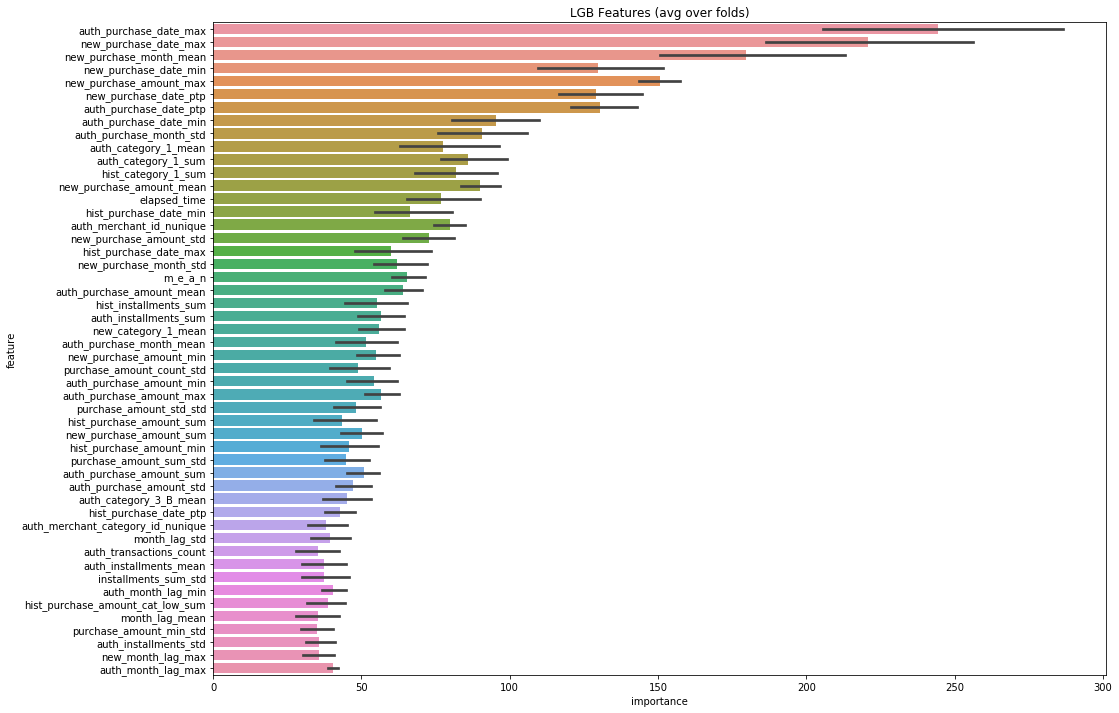

In [45]:
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', 
                                                          plot_feature_importance=True)

In [ ]:
CV mean score: 3.6621, std: 0.0321.  ## старый результат